<h1><center>Diplomado de Ciencias de Datos - Trabajo Final - Octubre 2021</center></h1> 
<h2><center>Caso Práctico: Sistema Provincial de Expedientes (SIE)</center></h2> 
<h3><center>4° Parte</center></h3>
<h4><center>Ing. Romina C. Scarazzini</center></h4>

___
# Contenido
- Limpieza de Datos con Power BI: Para ver el detalle de lo realizado en este paso, ver el documento: "Limpieza de Datos con Power BI.pdf"
- Exploración  y análisis de los datos
- Análisis de las características de Series Temporales (EDA)
- **Aplicación de modelos de Machine Learning, enfocados a Series Temporales**
  - **Paquetes de StatModels**
    - **Modelo Autorregresivo: Statsmodels.tsa.arima_model**
    - **Modelo Autorregresivo: Statsmodels.tsa.ar_model**
- Predicciones 2021

___
# Importación de Paquetes

In [8]:
# Instalación de paquetes para tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Instalación de paquetes para gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Declaración del estilo
#===================================
plt.style.use("bmh")

#Configuración del tamaño de las visualizaciones para que se muestren bien en Jupyter
#==============================================
plt.rcParams["figure.figsize"] = 16, 5

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Paquetes para la Evaluación de Error de los Modelos

In [2]:
# Error Porcentual Absoluto Medio (MAPE)
# Este es uno de lo más usados para Series de Tiempo
#==========================================================
from sklearn.metrics import mean_absolute_percentage_error

# Error absoluto medio: Mean Squared Error (MAE)
#==========================================================
from sklearn.metrics import mean_absolute_error

# Error cuadrático medio: Mean Squared Error (MSE)
#===================================================
from sklearn.metrics import mean_squared_error

#Error logarítmico cuadrático medio
#===================================================
from sklearn.metrics import mean_squared_log_error

## Importación de Statsmodels
Statsmodels es un módulo de Python que proporciona clases y funciones para la estimación de muchos modelos estadísticos diferentes, así como para realizar pruebas estadísticas y exploración de datos estadísticos.

In [3]:
# Para determinar la autocorrelación de una serie de tiempo
import statsmodels.graphics.tsaplots as sgt 

# Contiene la prueba de "Dickey Fuller" para saber si nuestra serie de tiempo es o no estacionaria
import statsmodels.tsa.stattools as sts 

# Modelo Autoregresivo (ARIMA)
from statsmodels.tsa.arima_model import ARMA

# Se usa en el Test de Contraste de Razon de Lob de Verosimilitudes (LLR Test) para el modelo ARIMA
from scipy.stats.distributions import chi2

#2° Modelo Autoregresivo (AR)
from statsmodels.tsa.ar_model import AR,ARResults

___
# Recupero los dataset trabajados en la 1° Parte del trabajo

In [4]:
# Defino como índice la 1° columna y diciendo que es una fecha
#======================================================================
df_total = pd.read_csv("df_total.csv", sep=';', index_col=0, parse_dates=True)
df_train = pd.read_csv("df_train.csv", sep=';', index_col=0, parse_dates=True)
df_test = pd.read_csv("df_test.csv", sep=';', index_col=0, parse_dates=True)
df_total.head()

,Cant_Expte
Fecha_Ini_Expte,
2011-01-03,1144.0
2011-01-04,1217.0
2011-01-05,1326.0
2011-01-06,1377.0
2011-01-07,1388.0


In [4]:
df_train.tail()

,Cant_Expte
Fecha_Ini_Expte,
2018-12-25,1197.0
2018-12-26,1197.0
2018-12-27,1150.0
2018-12-28,1574.0
2018-12-31,1.0


In [5]:
df_test.head()

,Cant_Expte
Fecha_Ini_Expte,
2019-01-01,1.0
2019-01-02,974.0
2019-01-03,1309.0
2019-01-04,1093.0
2019-01-07,1165.0


___
# Modelo Autorregresivo - ***statsmodels.tsa.arima_model***
## Autocorrelación (ACF) de los datos de Training de nuestra serie de tiempo
- Estamos buscando modelos simples, ya que estos resultan predictores más razonables que evitan el sobre ajuste del modelo a los datos y mientras más retrasos se incluyan, más se adapta a nuestro modelo el conjunto de datos con el que lo alimentamos
- Esto es un riesgo de Overfiting, es decir los coeficientes pueden predecir el conjunto de datos demasiado bien, lo cual hace que el modelo sea propenso a errores al intentar pronosticar valores futuros desconocidos

### Gráfico: Función de Autocorrelación para los datos de Training

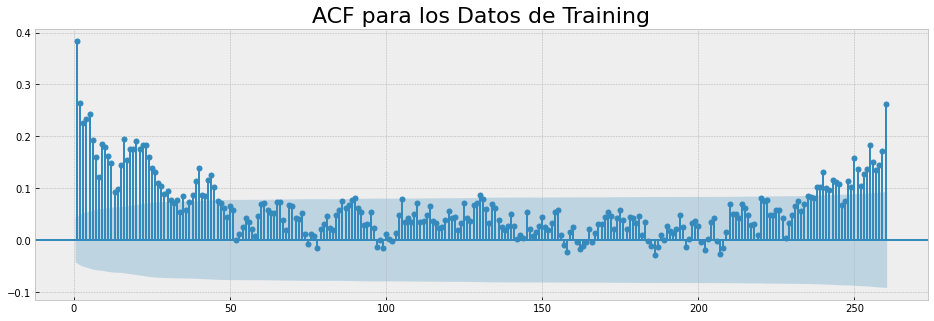

In [5]:
sgt.plot_acf(df_train.Cant_Expte, zero = False, lags = 260)
plt.title("ACF para los Datos de Training", size = 22);

### Análisis
- Esta función de autocorrelación captura los efectos directos e indirectos del valor anterior sobre el valor presente
- Aqui podemos ver que son significativos hasta 42 retrazos 
- Como estamos buscando un modelo eficiente, buscamos considerar aquellos retrasos que tengan un efecto directo y significativo sobre el período presente
- Por lo tanto debemos examinar la función de autocorrelación parcial bien antes de construir un modelo con 42 coeficientes de retraso

### Gráfico: Función de Autocorrelación Parcial para Expedientes

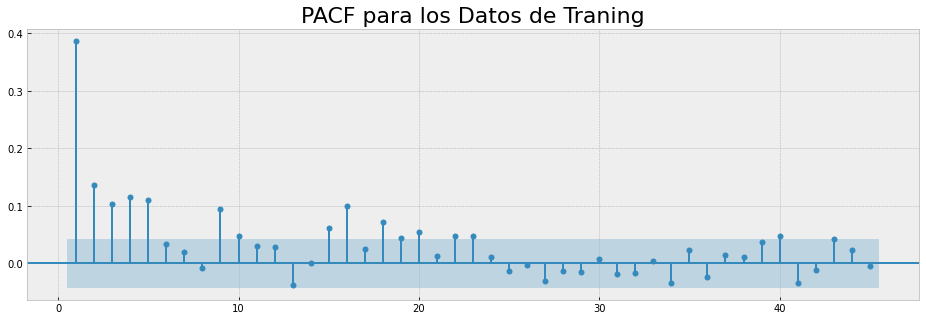

In [6]:
sgt.plot_pacf(df_train.Cant_Expte, lags = 45, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF para los Datos de Traning", size = 22);

#### Análisis y Conclusiones 
- Los coeficientes son de diferentes tamaños, hay coeficientes negativos 
- También hay muchos coeficientes que son en su mayoría no significativos
- A partir del retraso 24 en adelante los coeficientes son negativos y/o no significativos, es decir podríamos ignorarlos
- Vemos tambien que el primer retraso tiene mucho más impacto que el resto. Entonces el valor de nuestro primer retraso es muy significativo por lo que debemos incluirlo en nuestro modelo
- Los primero 5 coeficientes son los más significativos (coincide con la semana laboral)
>
- Vamos a comenzar con un modelo que incluya solo el primer retraso, que ajuste los datos y analize sus coeficientes

## Modelo Autorregresivo (ARIMA) de orden 1

In [9]:
''' En el parámetro "order", 1 representa el número de valores pasados que deseamos incorporar al modelo 
si estamos en un modelo auto regresivo de orden 1, vamos a incorporar sólo un retraso, y el 0 representa 
el hecho de que no estamos teniendo en cuenta los valores residuales'''
#=======================================================
model_arima1 = ARMA(df_train.Cant_Expte, order=(1,0))

In [10]:
'''hay que guardar los resultados haciendo un fit del modelo, es decir un ajuste de este modelo porque 
en la ceda anterior definimos el modelo y la variable que vamos a ajustar y el tipo de modelo.
Y luego aquí lo ajustamos y estos van a ser los resultados'''
#=======================================================
arima1fit = model_arima1.fit()

In [11]:
# Para ver los resultados hacemos un "sumary" y obtenemos un resumen estadístico
#=======================================================
arima1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                     ARMA(1, 0)   Log Likelihood              -15068.913
Method:                       css-mle   S.D. of innovations            331.907
Date:                Mon, 04 Oct 2021   AIC                          30143.826
Time:                        09:24:41   BIC                          30160.755
Sample:                    01-03-2011   HQIC                         30150.028
                         - 12-31-2018                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1466.4965     11.854    123.709      0.000    1443.262    1489.731
ar.L1.Cant_Expte     0.3872      0.020     19.092      0.000       0.347       0.427
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5829           +0.0000j            2.5829            0.0000
-----------------------------------------------------------------------------
"""

### Análisis y Conclusiones
- Vamos a analisar solo la parte inferior de la tabla
- La tabla que contiene dos coeficinetes. 
  - **const**: valor de la constante 
  - **ar.L1.Cant_Expte**: valor del coeficiente asociado al valor de la cantidad de expedientes para el período t-1 (el período anterior de un retraso)
>
- La columna **coef**: nos muestra las estimaciones de la contante y del coeficiente
>
- La columna **P>|z|**: el valor **P** es 0 (P es la probabilidad de la hipótesis nula) entonces si P e 0, la hipótesis nula es muy improbable y la vamos a rechazar. La hipótesis nula es que el coeficiente es 0 o significativamente igual a cero y la rechazamos
- Si tomamos un nivel de significación de 0.05 y como son los dos P son iguales a 0 diremos que **son significativamente distinto de cero**
>
- La columna **[0.025  0.975]**: es otra manera de analisar los resultados, mirando el **intervalo de confianza**
- Si el intervalo de confianza contiene al 0, entonces es equivalente a aceptar la hipótesis nula
- Si el intervalo de confianza no contiene el 0, entonces es equivalente a rechazar la hipótesis nula
- Aquí vemos que para ambos casos el intervalo de confianza no contiene al 0, por lo tanto este **coeficiente es significativo**
>
- Ahora que sabemos que los dos coeficientes son significativamente diferente de cero y podemos intentar ajustar a **un modelo más complejo**

## Modelo Autorregresivo (ARIMA) de orden p

In [12]:
#Modelo Autorregresivo de orden 2
#==========================================================
model_arima2 = ARMA(df_train.Cant_Expte, order=(2,0))
arima2fit = model_arima2.fit()
arima2fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                     ARMA(2, 0)   Log Likelihood              -15049.523
Method:                       css-mle   S.D. of innovations            328.833
Date:                Mon, 04 Oct 2021   AIC                          30107.047
Time:                        09:24:45   BIC                          30129.619
Sample:                    01-03-2011   HQIC                         30115.317
                         - 12-31-2018                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1466.2494     13.593    107.865      0.000    1439.607    1492.892
ar.L1.Cant_Expte     0.3343      0.022     15.337      0.000       0.292       0.377
ar.L2.Cant_Expte     0.1364      0.022      6.256      0.000       0.094       0.179
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7468           +0.0000j            1.7468            0.0000
AR.2           -4.1983           +0.0000j            4.1983            0.5000
-----------------------------------------------------------------------------
"""

In [13]:
#Modelo Autorregresivo de orden 3
#==========================================================
model_arima3 = ARMA(df_train.Cant_Expte, order=(3,0))
arima3fit = model_arima3.fit()
arima3fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                     ARMA(3, 0)   Log Likelihood              -15038.339
Method:                       css-mle   S.D. of innovations            327.072
Date:                Mon, 04 Oct 2021   AIC                          30086.679
Time:                        09:24:48   BIC                          30114.894
Sample:                    01-03-2011   HQIC                         30097.017
                         - 12-31-2018                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1466.0167     15.083     97.195      0.000    1436.454    1495.579
ar.L1.Cant_Expte     0.3204      0.022     14.644      0.000       0.277       0.363
ar.L2.Cant_Expte     0.1015      0.023      4.435      0.000       0.057       0.146
ar.L3.Cant_Expte     0.1037      0.022      4.742      0.000       0.061       0.147
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4545           -0.0000j            1.4545           -0.0000
AR.2           -1.2165           -2.2687j            2.5743           -0.3283
AR.3           -1.2165           +2.2687j            2.5743            0.3283
-----------------------------------------------------------------------------
"""

In [14]:
#Modelo Autorregresivo de orden 4
#==========================================================
model_arima4 = ARMA(df_train.Cant_Expte, order=(4,0))
arima4fit = model_arima4.fit()
arima4fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                     ARMA(4, 0)   Log Likelihood              -15024.472
Method:                       css-mle   S.D. of innovations            324.901
Date:                Mon, 04 Oct 2021   AIC                          30060.944
Time:                        09:24:52   BIC                          30094.802
Sample:                    01-03-2011   HQIC                         30073.349
                         - 12-31-2018                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1465.6670     16.936     86.543      0.000    1432.473    1498.861
ar.L1.Cant_Expte     0.3085      0.022     14.121      0.000       0.266       0.351
ar.L2.Cant_Expte     0.0900      0.023      3.940      0.000       0.045       0.135
ar.L3.Cant_Expte     0.0666      0.023      2.916      0.004       0.022       0.111
ar.L4.Cant_Expte     0.1154      0.022      5.284      0.000       0.073       0.158
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2845           -0.0000j            1.2845           -0.0000
AR.2            0.0595           -1.8446j            1.8456           -0.2449
AR.3            0.0595           +1.8446j            1.8456            0.2449
AR.4           -1.9804           -0.0000j            1.9804           -0.5000
-----------------------------------------------------------------------------
"""

#### Análisis y Conclusiones

- En los tres modelos se puede observar lo siguiente:
  - Los valores de la constante y de los coeficientes no son los mismos
  - Los valores de **P** son todos menores a 0 por lo cual **son coeficientes significativos**
  - Los **intervalos de confianzas** no incluyen el 0 por lo cual **son coeficientes significativos**
>
- Además:
  - Vemos que mientras más complejidad le vamos añadiendo al modelo, más aumenta el **logaritmo de la verosimilitud** como regla general vamos a preferir modelos con una mayor probabilidad del logaritmo de la verosimilitud
  - Vemos que los valores de los criterios ***AIC y BIC*** van disminuyendo. También vamos a preferir valores más bajos en estos dos criterios
 

___
## Test de Contraste de Razón de Lob de Verosimilitudes (LLR Test)
- Esto compara dos dos modelos y determina si son significativamente diferentes. Es como un contraste hipótesis aparte que se hace entre dos modelos
- Entonces en este contraste de hipótesis, la hipótesis nula va a decir que los dos modelos son significativamente iguales o significativamente similares y la hipótesis alternativa va a decir que los dos modelos son significativamente diferentes
- Vamos a construir una función para hacer este test y lo que nos va a devolver es un valor de probabilidad, con el cual vamos a ver si rechazamos la hipótesis nula o no

In [31]:
#LLR Test
# El párámetro "DF" (decrease of freedom), grado de libertad del estadístico. 
# Es igual a 1 porque es la diferencia entre la cantidad de parámetros entre los modelos. 
# En el modelo 1 tenemos dos parámetros y en el modelo 2 tenemos 3 parámetros
# El estadístico "LR" que hay que comprobar va a ser igual a dos veces la diferencia entre el LLR del 2° modelo que es más complejo que el primero y el LLR del 1° modelo
# A esto se aplica su distribución, que es la distribución del estadístico es una "chi cuadrado"
# "p" va a ser el valor de contraste de hipótesis, que va a devolver esta función 
#==============================================
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

### Comparación de Modelos de Autorregreción (ARIMA) de órdenes distintas

In [18]:
LLR_test(arima1fit, arima2fit)

0.0

In [19]:
LLR_test(arima2fit, arima3fit)

0.0

In [20]:
LLR_test(arima3fit, arima4fit)

0.0

#### Análisis y Conclusiones
- Vemos que todos los modelos son significativamente diferentes
- El **valor 0** de cada test comparándolo con el **nivel de significación de 0,05 es menor. Entonces rechazábamos la hipótesis nula
- Y si rechazamos la hipótesis nula que me dice que estos modelos son similares, esto significa que los modelos son significativamente diferentes
- Es mejor añadir complejidad al modelo
- Esto lo podemos hacer de manera repetitiva hasta encontrar un modelo que tenga un valor mayor al nivel de significación de 0,05. Mirando simultaneamente el P valor de los coeficientes en el resumen estadístico

### Seguimos aplicando el modelos Autocorrelación (ARIMA) en órdenes mayores

In [16]:
#Modelo Autorregresivo de orden 5 y su LLR Test comparado con el modelo 4
#==========================================================================
model_arima5 = ARMA(df_train.Cant_Expte, order=[5,0])
arima5fit = model_arima5.fit()
print(arima5fit.summary()) 

#Ejecuto e imprimo el resultado del de mi función "LLR_test" para verla junto al resumen estadístico
print ("LLR test: " + str(LLR_test(arima4fit, arima5fit)))

                              ARMA Model Results                              
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                     ARMA(5, 0)   Log Likelihood              -15011.909
Method:                       css-mle   S.D. of innovations            322.945
Date:                Mon, 04 Oct 2021   AIC                          30037.818
Time:                        09:24:59   BIC                          30077.319
Sample:                    01-03-2011   HQIC                         30052.291
                         - 12-31-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1465.2442     18.909     77.488      0.000    1428.183    1502.306
ar.L1.Cant_Expte     0.2959      0.022     13.536      0.000       0.253       0.339
ar.L2.Cant_Expte     0.0827 

In [17]:
# Modelo Autorregresivo de orden 6 y su LLR Test comparado con el modelo 5
#===========================================================================
model_arima6 = ARMA(df_train.Cant_Expte, order=[6,0])
arima6fit = model_arima6.fit()
print(arima6fit.summary()) 
print ("LLR test: " + str(LLR_test(arima5fit, arima6fit)))

                              ARMA Model Results                              
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                     ARMA(6, 0)   Log Likelihood              -15010.748
Method:                       css-mle   S.D. of innovations            322.765
Date:                Mon, 04 Oct 2021   AIC                          30037.496
Time:                        09:25:02   BIC                          30082.640
Sample:                    01-03-2011   HQIC                         30054.036
                         - 12-31-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1465.1167     19.553     74.930      0.000    1426.793    1503.440
ar.L1.Cant_Expte     0.2922      0.022     13.297      0.000       0.249       0.335
ar.L2.Cant_Expte     0.0800 

In [36]:
# Modelo Autorregresivo de orden 22 y su LLR Test comparado con el modelo 5
#===========================================================================
model_arima22 = ARMA(df_train.Cant_Expte, order=[22,0])
arima22fit = model_arima22.fit()
print(arima22fit.summary()) 
print ("LLR test: " + str(LLR_test(arima5fit, arima22fit)))

                              ARMA Model Results                              
Dep. Variable:             Cant_Expte   No. Observations:                 2086
Model:                    ARMA(22, 0)   Log Likelihood              -14968.324
Method:                       css-mle   S.D. of innovations            316.221
Date:                Mon, 04 Oct 2021   AIC                          29984.649
Time:                        09:41:42   BIC                          30120.081
Sample:                    01-03-2011   HQIC                         30034.270
                         - 12-31-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1458.0580     35.397     41.192      0.000    1388.682    1527.434
ar.L1.Cant_Expte      0.2700      0.022     12.300      0.000       0.227       0.313
ar.L2.Cant_Expte      0.

#### Análisis y Conclusiones
- Vemos que el Modelo Autorregresivo de orden 6, tanto el P valor como el resultado del LLR Test son mayores al nivel de significación seleccionado de "0,05. Por lo cual concluimos que los modelos de orden 5 y 6 son significativamente similares
- Entonces nos quedaríamos con el Modelo de Autorregresion de orden 5, ya que es un modelo mas simple
- Esto indica que debemos tener en cuenta la cantidad de expediente iniciados de 5 días atrás

Ahora vamos a comparar el modelo que tiene sólo 1 retraso y el modelo con 5 retrasos, para ver si adicionar 4 retrasos más, mejora las predicciones

In [18]:
# LLR Test entre el modeo 5 y el modelo 1
# Aquí el DF es igual a 4 ya que el modelo 1 tiene 2 parámetros y el modelo 5 tiene 6 parámetros
#===========================================================================
print ("LLR test: " + str(LLR_test(arima1fit, arima5fit, DF = 4)))

LLR test: 0.0


### Análisis y conclusiones finales
- Concluimos que el **Modelo de Autorregresion de orden 5** es nuestro mejor modelo, ya que añadir más complejidad y es significativamente mejor
- Los modelos Autoregresivos modelan mejor la serie de tiempo que son estacionarias y funcionan peor para serie de tiempo no estacionarias y como aplicamos anteriomente a nuestra serie de tiempo el método de "Dickey Fuller" ya hemos comprobado que nuestra serie sí es estacionaria

___
## Análisis de Residuos (ARIMA)

In [19]:
#Obtengo los residuos del modelo 5 y los guardo en mi dataset
#============================================================
df_train['Res_Cant_Expte'] = arima5fit.resid

In [31]:
df_train.head()

,Cant_Expte,Res_Cant_Expte
Fecha_Ini_Expte,,
2011-01-03,1144.0,-321.244199
2011-01-04,1217.0,-123.732175
2011-01-05,1326.0,-12.305566
2011-01-06,1377.0,14.984324
2011-01-07,1388.0,16.136744


Los residuos deben que ser semejantes al "Ruido blanco" es decir no se debe tener autocorrelación y y en el test de Dicky Fuller deberíamos obtener que los residuos son significativamente estacionarios

In [20]:
#Aplico el método de Dicky Fuller en los residuos
#============================================
sts.adfuller(df_train.Res_Cant_Expte)

(-6.06711017831451,
 1.1745859181808335e-07,
 23,
 2062,
 {'1%': -3.4335252955005657,
  '5%': -2.8629426977513854,
  '10%': -2.567516732429506},
 29611.470879109875)

#### Conclusiones
- Tenemos un P valor bajísimo: "1.1745859181808335e-07", el cual es mucho menor que los niveles de significación: 0,05
- Además, mirando el valor del "Estadístico de Constraste" o "Estadístico de Prueba": "-6.06711017831451" y comparándolo con los valores críticos: "-3.4335252955005657", "-2.8629426977513854" y "-2.567516732429506", vemos que es menor a dichos valores
- Esto quiere decir que el **ruido blanco es estacionario**

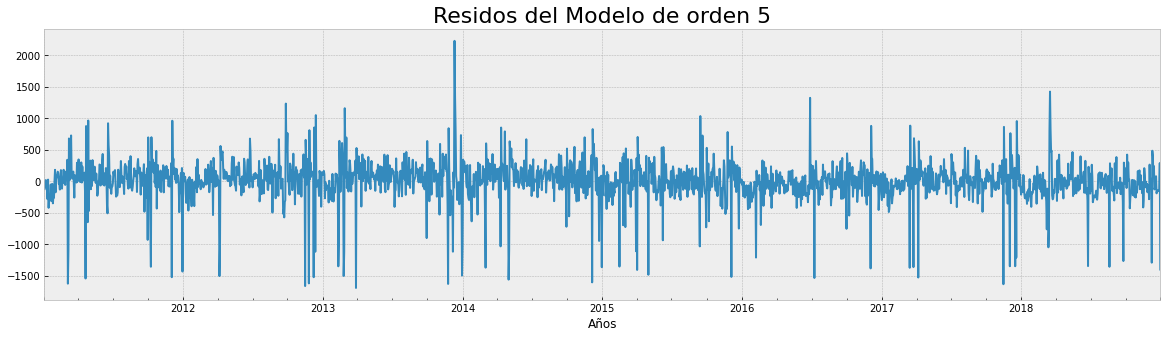

In [21]:
# Grafico el Ruido Blanco del modelo 5
#=================================================================
df_train.Res_Cant_Expte[1:].plot(figsize=(20,5))
plt.title("Residos del Modelo de orden 5",size=22)
plt.xlabel("Años");

#### Conclusiones
Vemos que no hay ningún patron

### Gráfico: Verificamos el Residuo del Modelo de autocorrelación (ARIMA) de orden 5

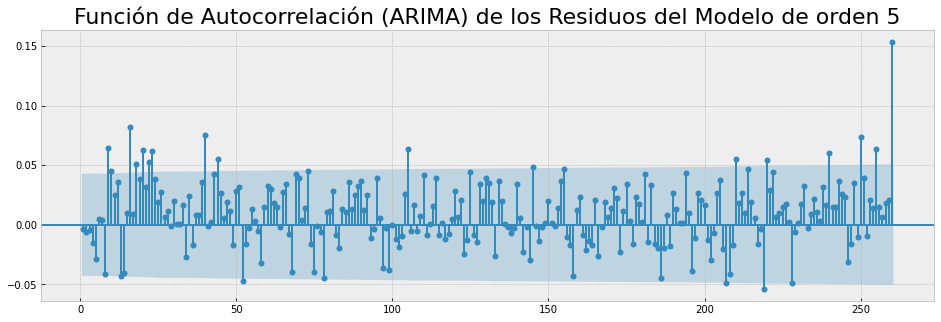

In [22]:
# Lo hacemos hasta 260 retrasos
#=============================================================================
sgt.plot_acf(df_train.Res_Cant_Expte, zero = False, lags = 260)
plt.title("Función de Autocorrelación (ARIMA) de los Residuos del Modelo de orden 5",size=22);

#### Conclusiones
La mayoría de los valores caen dentro del área azul, por lo cual no son significativamente distintos de cero, eso significa que son significativamente iguales a cero, es decir que **no hay autocorrelación**

### Predicciones: Modelo Autorregresivo (ARIMA) de orden 5

In [38]:
start=len(df_train)
end=len(df_train)+len(df_test)-1

pred_arima5 = arima5fit.predict(start=start, end=end, dynamic=False).rename('pred_arima5')
pred_arima22 = arima5fit.predict(start=start, end=end, dynamic=False).rename('pred_arima22')

### Gráfico: Datos de Trainning, Test y las Predicciones con el Modelo Autorregresivo (ARIMA) de orden 5

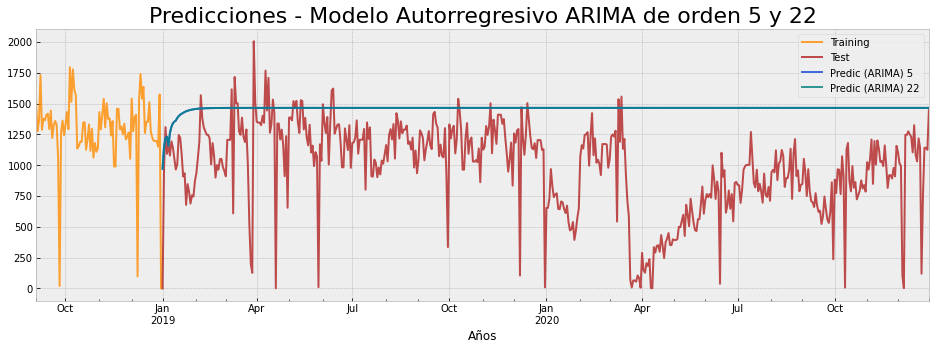

In [44]:
fig, ax=plt.subplots()
df_train['Cant_Expte'].iloc[2000:].plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
df_test['Cant_Expte'].plot(ax=ax, label='Test',color="firebrick", alpha=0.8)
pred_arima5.plot(ax=ax, label='Predic (ARIMA) 5', color="royalblue", alpha=1)
pred_arima22.plot(ax=ax, label='Predic (ARIMA) 22', color="teal", alpha=0.8)
plt.title("Predicciones - Modelo Autorregresivo ARIMA de orden 5 y 22", fontsize=22)
plt.xlabel("Años")
ax.legend();
#.iloc[2000:]

___
## Evaluación del Error del Modelo ARIMA

### MAE (Error Absoluto Medio)

In [46]:
labels = ['ARIMA(5)','ARIMA(22)']
predic = [pred_arima5, pred_arima22]  # Estas son variables, no son strings

for i in range(2):
    error = mean_absolute_error(df_test['Cant_Expte'], predic[i])
    print(f'MAE {labels[i]}: {error:11.10}')

MAE ARIMA(5): 493.0649726
MAE ARIMA(22): 493.0649726


### MAPE (Error Porcentual Absoluto Medio)

In [47]:
labels = ['ARIMA(5)','ARIMA(22)']
predic = [pred_arima5, pred_arima22]  # Estas son variables, no son strings

for i in range(2):
    error = mean_absolute_percentage_error(df_test['Cant_Expte'], predic[i])
    print(f'MAPE {labels[i]}: {error:11.10}')

MAPE ARIMA(5): 12.43365666
MAPE ARIMA(22): 12.43365666


### MSE (Error Cuadrático Medio)

In [48]:
labels = ['ARIMA(5)','ARIMA(22)']
predic = [pred_arima5, pred_arima22]  # Estas son variables, no son strings

for i in range(2):
    error = mean_squared_error(df_test['Cant_Expte'], predic[i])
    print(f'MAPE {labels[i]}: {error:11.10}')

MAPE ARIMA(5): 361015.7382
MAPE ARIMA(22): 361015.7382


#### Conclusiones
- Vemos que tiene un **MAPE:12,43%** aceptable, pero **la gráfica no realiza un buena predicción de la serie**
 - El valor del MAPE es mayor al del modelo FARC-SK-O que es de 8,22%

___
# Modelo Autorregresivo - ***statsmodels.tsa.ar_model***

## Modelo Autorregrevivo (ar) de orden 1

In [51]:
# En el fit, el parámetro maxlag=1 significa que solo voy a considerar 1 retrazo
# Si maxlag fuera 8, significaría que quiero considerar hasta 8 retrasos y me consideraría todos los modelos intermedios considerando un retraso hasta llegar a 8

# En el fit, el parámetro method='mle significa que debe estimar los coeficientes con el método de máxima verosimilitud.
# Maximum Littlewood estimator (mle) es un método que maximizando la verosimilitud, logra estimar los parámtetros de manera eficiente y consistente
#======================================================================
model1 = AR(df_train['Cant_Expte'])
AR1fit = model1.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const            898.895736
L1.Cant_Expte      0.387049
dtype: float64


Como es un modelo regresivo de orden 1, sólo tengo la constante y el coeficiente asociado al Valor de la variable en el periodo t-1

### Predicciones

In [52]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
pred_ar1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('pred_ar1')

In [40]:
pred_ar1

2019-01-01     899.282785
2019-01-02    1246.962368
2019-01-03    1381.531453
2019-01-04    1433.616302
2019-01-07    1453.775698
                 ...     
2020-12-24    1466.505393
2020-12-25    1466.505393
2020-12-28    1466.505393
2020-12-29    1466.505393
2020-12-30    1466.505393
Freq: B, Name: pred_ar1, Length: 522, dtype: float64

In [53]:
# Comparando predicciones con valores reales
#============================================================
for i in range(len(pred_ar1)-510):
    print(f"Predecido={pred_ar1[i]}, Esperado={df_test['Cant_Expte'][i]}")

Predecido=899.282785178493, Esperado=1.0
Predecido=1246.9623680547804, Esperado=974.0
Predecido=1381.5314529170819, Esperado=1309.0
Predecido=1433.6163019923895, Esperado=1093.0
Predecido=1453.7756982309347, Esperado=1165.0
Predecido=1461.5783752841999, Esperado=1078.0
Predecido=1464.5983947568634, Esperado=1194.0
Predecido=1465.767290707959, Esperado=1145.0
Predecido=1466.2197108849991, Esperado=1055.0
Predecido=1466.3948197271516, Esperado=965.0
Predecido=1466.4625954545754, Esperado=1007.0
Predecido=1466.4888279918437, Esperado=1245.0


### Gráfico: Valores Reales vs Valores Predecidos para el modelo (ar) de orden 1

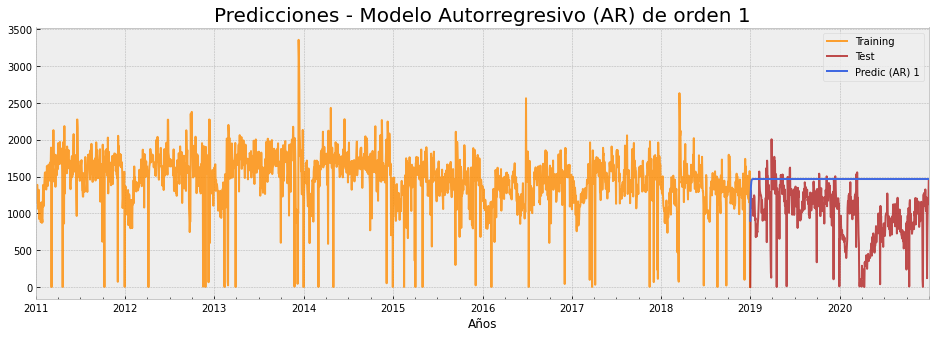

In [54]:
fig, ax=plt.subplots()
df_train['Cant_Expte'].plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
df_test['Cant_Expte'].plot(ax=ax, label='Test',color="firebrick", alpha=0.8)
pred_ar1.plot(ax=ax, label='Predic (AR) 1', color="royalblue", alpha=1)
plt.title("Predicciones - Modelo Autorregresivo (AR) de orden 1", fontsize=20)
plt.xlabel("Años")
ax.legend();
#.iloc[2000:]

#### Conclusiones
- Vemos en el gráfico que el modelo (AR)de orden 1, no es un buen estimador para los valores de nuestra serie. Es decir que el retraso de un 1 día anterior no es suficiente

## Modelo Autorregrevivo (AR) de orden 2

In [55]:
# Genero el modelo (ar) de orden 2
#=============================================
model2 = AR(df_train['Cant_Expte'])
AR2fit = model2.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const            776.632335
L1.Cant_Expte      0.334128
L2.Cant_Expte      0.136212
dtype: float64


In [57]:
# Genero los predicciones para el modelo (AR) de orden 2
#=================================================================
pred_ar2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('pred_ar2')

### Gráfico: Valores Reales vs Valores Predecidos para el modelo (ar) de orden 1 y 2

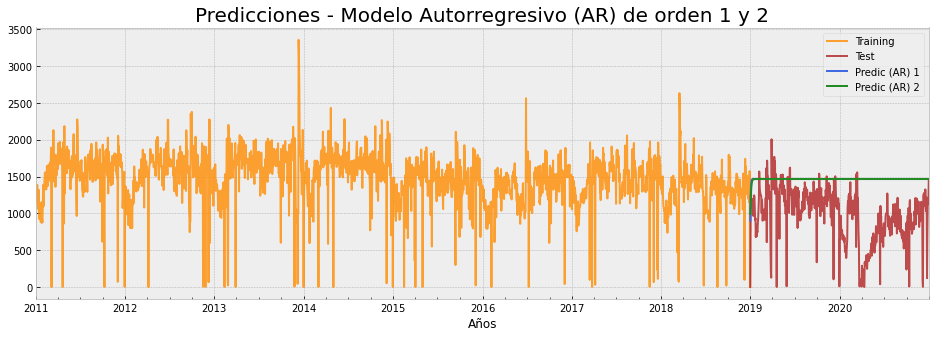

In [58]:
fig, ax=plt.subplots()
df_train['Cant_Expte'].plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
df_test['Cant_Expte'].plot(ax=ax, label='Test',color="firebrick", alpha=0.8)
pred_ar1.plot(ax=ax, label='Predic (AR) 1', color="royalblue", alpha=1)
pred_ar2.plot(ax=ax, label='Predic (AR) 2', color="forestgreen", alpha=1)
plt.title("Predicciones - Modelo Autorregresivo (AR) de orden 1 y 2", fontsize=20)
plt.xlabel("Años")
ax.legend();
#.iloc[2000:]

#### Conclusiones
- Vemos en el gráfico que el modelo (AR)de orden 2, no es un buen estimador para los valores de nuestra serie. Es decir que el retraso de un 2 días anteriores no es suficiente

## Modelo Autorregrevivo (AR) donde Statsmodels elige "p"
### Ajuste del modelo
- El párametro "ic" viene por defecto con el valor "NONE", por lo cual el coeficiente de retorno máximo va a ser la longitud por defecto que pongamos al parámetro "maxlag" que se usa antes.
- Sino definimos es parámetro "maxlag" y definimos "ic" con algun criterio, entonces el algoritmo va a devolver la cantidad de retornos "p" que deberíamos considerar, según el criterio seleccionado. Hay varios criterios oara estimar la cantidad de retornos:
  - 'aic': Akaike Information Criterion
  - 'bic': Bayes Information Criterion
  - 't-stat': Based on last lag
  - 'hqic': Hannan-Quinn Information Criterion

### Genero el modelo (AR) de orden "p"
#### Hiperparámetro ic = 'aic'

In [59]:
model_aic = AR(df_train['Cant_Expte'])
AR_aic_fit = model_aic.fit(ic='aic')
print(f'Lag: {AR_aic_fit.k_ar}')
print(f'Coefficients:\n{AR_aic_fit.params}')

Lag: 23
Coefficients:
const             288.758934
L1.Cant_Expte       0.265819
L2.Cant_Expte       0.064697
L3.Cant_Expte       0.042252
L4.Cant_Expte       0.059685
L5.Cant_Expte       0.077859
L6.Cant_Expte       0.007319
L7.Cant_Expte      -0.000827
L8.Cant_Expte      -0.042715
L9.Cant_Expte       0.073852
L10.Cant_Expte      0.031291
L11.Cant_Expte      0.008033
L12.Cant_Expte      0.025733
L13.Cant_Expte     -0.059796
L14.Cant_Expte     -0.036679
L15.Cant_Expte      0.021048
L16.Cant_Expte      0.079072
L17.Cant_Expte     -0.005635
L18.Cant_Expte      0.047545
L19.Cant_Expte      0.022238
L20.Cant_Expte      0.045426
L21.Cant_Expte     -0.004148
L22.Cant_Expte      0.033682
L23.Cant_Expte      0.048067
dtype: float64


#### Hiperparámetro ic = 't-stat' 

In [60]:
model_aic = AR(df_train['Cant_Expte'])
AR_t_stat_fit = model_aic.fit(ic='t-stat')
print(f'Lag: {AR_t_stat_fit.k_ar}')
print(f'Coefficients:\n{AR_t_stat_fit.params}')

Lag: 23
Coefficients:
const             288.758934
L1.Cant_Expte       0.265819
L2.Cant_Expte       0.064697
L3.Cant_Expte       0.042252
L4.Cant_Expte       0.059685
L5.Cant_Expte       0.077859
L6.Cant_Expte       0.007319
L7.Cant_Expte      -0.000827
L8.Cant_Expte      -0.042715
L9.Cant_Expte       0.073852
L10.Cant_Expte      0.031291
L11.Cant_Expte      0.008033
L12.Cant_Expte      0.025733
L13.Cant_Expte     -0.059796
L14.Cant_Expte     -0.036679
L15.Cant_Expte      0.021048
L16.Cant_Expte      0.079072
L17.Cant_Expte     -0.005635
L18.Cant_Expte      0.047545
L19.Cant_Expte      0.022238
L20.Cant_Expte      0.045426
L21.Cant_Expte     -0.004148
L22.Cant_Expte      0.033682
L23.Cant_Expte      0.048067
dtype: float64


In [78]:
# Genero los predicciones para el modelo (AR) de orden 23
#=================================================================
pred_ar23 = AR_aic_fit.predict(start=start,end=end,dynamic=False).rename('pred_ar23')
pred_ar22 = AR_aic_fit.predict(start=start,end=end,dynamic=False).rename('pred_ar22')

#### Gráfico: Valores Reales vs Valores Predecidos para el modelo (ar) de orden 1, 2 y 23

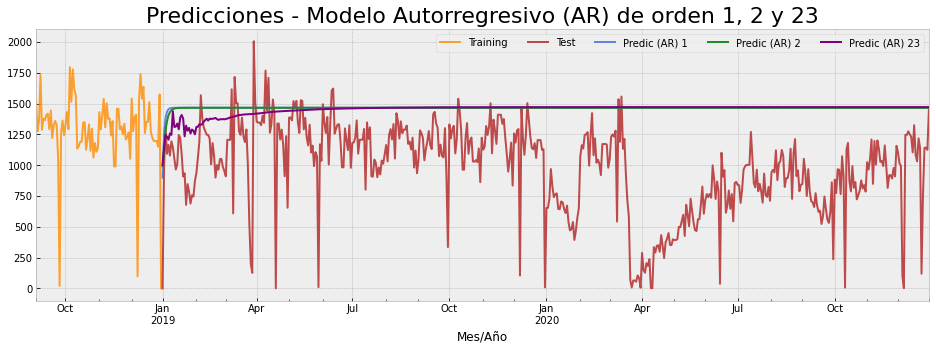

In [81]:
fig, ax=plt.subplots()
df_train['Cant_Expte'].iloc[2000:].plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
df_test['Cant_Expte'].plot(ax=ax, label='Test',color="firebrick", alpha=0.8)
pred_ar1.plot(ax=ax, label='Predic (AR) 1', color="royalblue", alpha=0.8)
pred_ar2.plot(ax=ax, label='Predic (AR) 2', color="forestgreen", alpha=1)
pred_ar23.plot(ax=ax, label='Predic (AR) 23', color="purple", alpha=1)
plt.title("Predicciones - Modelo Autorregresivo (AR) de orden 1, 2 y 23", fontsize=22)
plt.xlabel("Mes/Año")
plt.xticks()
plt.FixedLocator(mdates.YearLocator())
plt.FixedFormatter(mdates.DateFormatter('%Y'))
#plt.tight_layout(pad=1.5)
plt.legend(loc="upper right", ncol=5);
#.iloc[2000:]

#### Hiperparámetro ic = 'bic'

In [63]:
model_bic = AR(df_train['Cant_Expte'])
AR_bic_fit = model_bic.fit(ic='bic')
print(f'Lag: {AR_bic_fit.k_ar}')
print(f'Coefficients:\n{AR_bic_fit.params}')

Lag: 5
Coefficients:
const            547.097183
L1.Cant_Expte      0.295713
L2.Cant_Expte      0.082716
L3.Cant_Expte      0.056935
L4.Cant_Expte      0.081464
L5.Cant_Expte      0.110075
dtype: float64


In [64]:
# Genero los predicciones para el modelo (ar) de orden 5
#=================================================================
pred_ar5 = AR_bic_fit.predict(start=start,end=end,dynamic=False).rename('pred_ar5')

#### Gráfico: Valores Reales vs Valores Predecidos para el modelo (ar) de orden 1, 2, 5 y 23

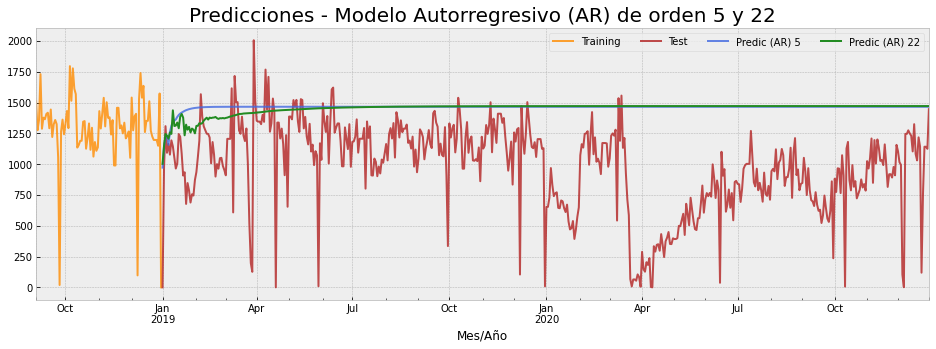

In [85]:
fig, ax=plt.subplots()
df_train['Cant_Expte'].iloc[2000:].plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
df_test['Cant_Expte'].plot(ax=ax, label='Test',color="firebrick", alpha=0.8)
#pred_ar1.plot(ax=ax, label='Predic (AR) 1', color="royalblue", alpha=0.8)
#pred_ar2.plot(ax=ax, label='Predic (AR) 2', color="forestgreen", alpha=0.8)
pred_ar5.plot(ax=ax, label='Predic (AR) 5', color="royalblue", alpha=0.8)
#pred_ar23.plot(ax=ax, label='Predic (AR) 23', color="purple", alpha=1)
pred_ar22.plot(ax=ax, label='Predic (AR) 22', color="forestgreen", alpha=1)
plt.title("Predicciones - Modelo Autorregresivo (AR) de orden 5 y 22", fontsize=20)
plt.xlabel("Mes/Año")
plt.legend(loc="upper right", ncol=6);

#.iloc[2000:]

#### Hiperparámetro ic = 'hqic'

In [86]:
model_hqic = AR(df_train['Cant_Expte'])
AR_hqic_fit = model_hqic.fit(ic='hqic')
print(f'Lag: {AR_hqic_fit.k_ar}')
print(f'Coefficients:\n{AR_hqic_fit.params}')

Lag: 20
Coefficients:
const             320.806370
L1.Cant_Expte       0.269007
L2.Cant_Expte       0.067169
L3.Cant_Expte       0.046583
L4.Cant_Expte       0.063275
L5.Cant_Expte       0.081597
L6.Cant_Expte       0.010685
L7.Cant_Expte       0.002988
L8.Cant_Expte      -0.043498
L9.Cant_Expte       0.069816
L10.Cant_Expte      0.029985
L11.Cant_Expte      0.010156
L12.Cant_Expte      0.028145
L13.Cant_Expte     -0.055148
L14.Cant_Expte     -0.035450
L15.Cant_Expte      0.019620
L16.Cant_Expte      0.080691
L17.Cant_Expte     -0.000765
L18.Cant_Expte      0.054984
L19.Cant_Expte      0.028293
L20.Cant_Expte      0.053862
dtype: float64


In [87]:
# Genero los predicciones para el modelo (ar) de orden 20
#=================================================================
pred_ar20 = AR_hqic_fit.predict(start=start,end=end,dynamic=False).rename('pred_ar20')

#### Gráfico: Valores Reales vs Valores Predecidos para el modelo (ar) de orden 1, 2, 5, 20 y 23

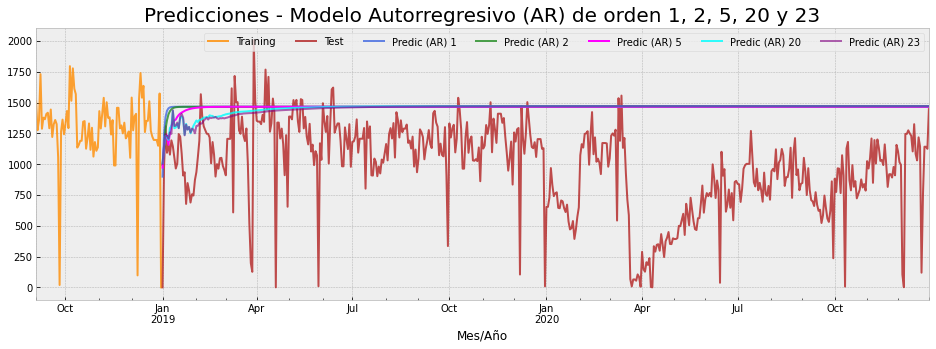

In [88]:
fig, ax=plt.subplots()
df_train['Cant_Expte'].iloc[2000:].plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
df_test['Cant_Expte'].plot(ax=ax, label='Test',color="firebrick", alpha=0.8)
pred_ar1.plot(ax=ax, label='Predic (AR) 1', color="royalblue", alpha=0.8)
pred_ar2.plot(ax=ax, label='Predic (AR) 2', color="forestgreen", alpha=0.8)
pred_ar5.plot(ax=ax, label='Predic (AR) 5', color="magenta", alpha=1)
pred_ar20.plot(ax=ax, label='Predic (AR) 20', color="aqua", alpha=0.8)
pred_ar23.plot(ax=ax, label='Predic (AR) 23', color="purple", alpha=0.6)
plt.title("Predicciones - Modelo Autorregresivo (AR) de orden 1, 2, 5, 20 y 23", fontsize=20)
plt.xlabel("Mes/Año")
plt.legend(loc="upper right", ncol=7);
#.iloc[2000:]

#### Conclusiones
- Usando el hiperparámetro "ic" con los valores "bic" , nos dice que el mejor modelo es el de orden 5
 - Usando el hiperparámetro "ic" con los valores "aic" o "hqic", nos dice que el mejor modelo es el de orden 20
- Usando el hiperparámetro "ic" con los valores "aic" o "t-stat", nos dice que el mejor modelo es el de orden 23
- Vemos en el gráfica que ninguno de estos modelos estima bien los valores reales que tenemos en nuestra serie

___
## Evaluación del Error del Modelo AR

### MAE (Error Absoluto Medio)

In [91]:
labels = ['AR(1)','AR(2)','AR(5)', 'AR(20)', 'AR(22)', 'AR(23)']
predic = [pred_ar1, pred_ar2, pred_ar5, pred_ar20, pred_ar22, pred_ar23]  # Estas son variables, no son strings

for i in range(6):
    error = mean_absolute_error(df_test['Cant_Expte'], predic[i])
    print(f'MAE {labels[i]}: {error:11.10}')

MAE AR(1):  497.396878
MAE AR(2): 496.6343506
MAE AR(5):  494.068652
MAE AR(20): 490.4741677
MAE AR(22): 488.2662924
MAE AR(23): 488.2662924


### MAPE (Error Porcentual Absoluto Medio)

In [92]:
labels = ['AR(1)','AR(2)','AR(5)', 'AR(20)', 'AR(22)', 'AR(23)']
predic = [pred_ar1, pred_ar2, pred_ar5, pred_ar20, pred_ar22, pred_ar23]  # Estas son variables, no son strings

for i in range(6):
    error = mean_absolute_percentage_error(df_test['Cant_Expte'], predic[i])
    print(f'MAPE {labels[i]}: {error:11.10}')

MAPE AR(1): 12.30787667
MAPE AR(2): 12.48187651
MAPE AR(5): 12.44356828
MAPE AR(20): 12.49935966
MAPE AR(22): 12.45953181
MAPE AR(23): 12.45953181


### MSE (Error Cuadrático Medio)

In [93]:
labels = ['AR(1)','AR(2)','AR(5)', 'AR(20)', 'AR(22)', 'AR(23)']
predic = [pred_ar1, pred_ar2, pred_ar5, pred_ar20, pred_ar22, pred_ar23]  # Estas son variables, no son strings

for i in range(6):
    error = mean_squared_error(df_test['Cant_Expte'], predic[i])
    print(f'MSE {labels[i]}: {error:11.10}')

MSE AR(1): 363992.8072
MSE AR(2): 363757.7218
MSE AR(5): 362092.3584
MSE AR(20): 360205.5248
MSE AR(22): 358772.6475
MSE AR(23): 358772.6475


#### Conclusiones
- El MAPE de todos los modelos es aceptable
- Pero vemos en el gráfico que ninguno de los modelo predice bien a nuestra serie de tiempo

___
### Medida de la calidad de los modelos AR
#### AIC - Criterio de Información de Akaike
- Es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos
- Proporciona un medio para la selección del modelo
- Maneja un trade-off entre la bondad de ajuste del modelo y la complejidad del modelo
- El modelo preferido es el que tiene el valor mínimo en el AIC. Por lo tanto AIC no solamente recompensa la bondad de ajuste, sino también incluye una penalidad, que es una función creciente del número de parámetros estimados. Esta penalización desalienta el sobreajuste

In [72]:
models = [AR1fit,AR2fit,AR_bic_fit,AR_hqic_fit,AR_aic_fit]

for i in range(5):
    print(f'{labels[i]} AIC: {models[i].aic:6.5}')

AR(1) AIC: 11.613
AR(2) AIC: 11.595
AR(5) AIC: 11.564
AR(20) AIC: 11.542
AR(23) AIC: 11.542


#### BIC Criterio de información bayesiano 
- Es un criterio para la selección de modelos entre un conjunto finito de modelos
- Se basa, en parte, en la función de probabilidad y que está estrechamente relacionado con el Criterio de Información de Akaike (AIC)
- Con el ajuste de modelos, es posible aumentar la probabilidad mediante la adición de parámetros, pero si lo hace puede resultar en sobreajuste. Tanto el BIC y AIC resuelven este problema mediante la introducción de un término de penalización para el número de parámetros en el modelo, el término de penalización es mayor en el BIC que en el AIC

In [73]:
models = [AR1fit,AR2fit,AR_bic_fit,AR_hqic_fit,AR_aic_fit]

for i in range(5):
    print(f'{labels[i]} BIC: {models[i].bic:6.5}')

AR(1) BIC: 11.621
AR(2) BIC: 11.606
AR(5) BIC: 11.583
AR(20) BIC: 11.602
AR(23) BIC:  11.61


#### HQIC: Hannan-Quinn Information Criterion
- En estadística, el criterio de información de Hannan-Quinn (HQC) es un criterio para la selección del modelo
- Es una alternativa al Criterio de Información de Akaike (AIC) y el criterio de información bayesiano (BIC)

In [74]:
models = [AR1fit,AR2fit,AR_bic_fit,AR_hqic_fit,AR_aic_fit]

for i in range(5):
    print(f'{labels[i]} hqic: {models[i].hqic:6.5}')

AR(1) hqic: 11.616
AR(2) hqic: 11.599
AR(5) hqic: 11.571
AR(20) hqic: 11.564
AR(23) hqic: 11.567


### Conclusiones
- En cada medición del modelo ya sea con AIC, BIC y HQIC, vemos que los valores disminuyen a medida que aumenta el orden del modelo, lo cual es bueno
- Igualmente vemos que son valores alto lo cual coincide con lo que ya concluido que dichos moldelos son son buenos para predecir los valores en nuestra serie de tiempo

___
## Predicciones Finales
#### Entrenamos el modelo "menos malo" con el dataset completo (statsmodels.tsa.ar_model (AR) de ordne 23

In [75]:
model = AR(df_total['Cant_Expte'])
AR23fit = model.fit(maxlag=23,method='mle')

In [76]:
# Genemramos las predicciones
#=======================================
predic_ar_23f = AR23fit.predict(start=len(df_total), end=len(df_total)+260, dynamic=False).rename('Predic_23')

#### Gráfico: Dataset completo y predicciones del modelo (AR) de orden 23

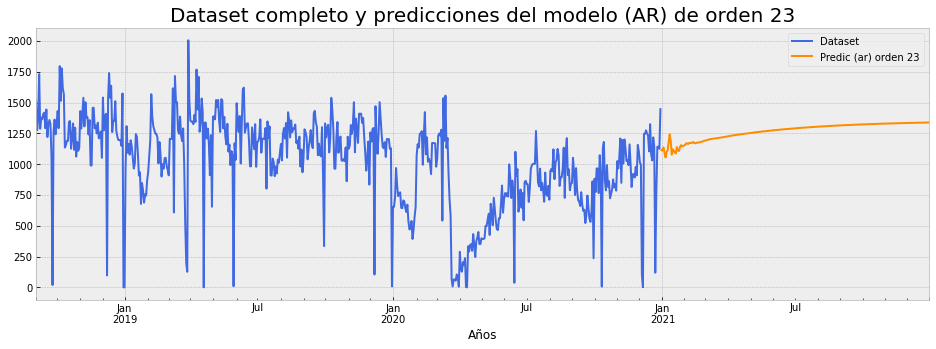

In [77]:
fig, ax=plt.subplots()
df_total['Cant_Expte'].iloc[2000:].plot(ax=ax, label='Dataset', color="royalblue", alpha=1)
predic_ar_23f.plot(ax=ax, label='Predic (ar) orden 23', color="darkorange", alpha=1)
plt.title("Dataset completo y predicciones del modelo (AR) de orden 23", fontsize=20)
plt.xlabel("Años")
ax.legend();
#.iloc[2000:]

___
## Conclusiones
- Los **modelos Autorregresivo (Statsmodels.tsa.arima_model)** y **Autorregresivo (Statsmodels.tsa.ar_modelModelo) no son buenos para predecir** los datos de nuestra serie de tiempo